In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

# save file location
results_file = 'dataset/henry_merge_sc10x_cellreports_nonimmune.h5ad'
adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 91169 × 24339 
    obs: 'samples', 'orig.ident', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'percent.mito', 'res.1', 'tree.ident', 'res1', 'res1-Stress', 'res.0.5', 'res0.5', 'Lin', 'Merge_Epi.dws.sc_St.dws.sc', 'Merge_Epi.dws.sc_St.dws.sc_NE', 'msamples', 'patient', 'res.0.2', 'res0.2', 'Merge_Epi.dws_St.go', 'Merge_Epi.dws_St.go_NE', 'mLin', 'nCount_RNA', 'nFeature_RNA', 'celltype', 'BE_score', 'HE_score', 'CE_score', 'LE-KLK3_score', 'LE-KLK4_score', 'Fibroblast_score', 'Endothelial_score'
    var: 'name'

normalizing counts per cell
    finished (0:00:06)


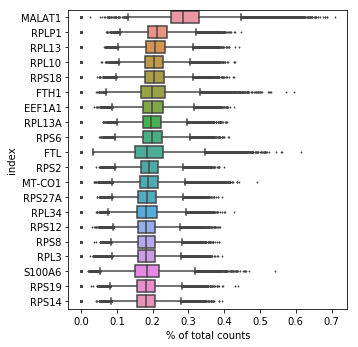

In [2]:
# plot higest expr genes
sc.pl.highest_expr_genes(adata, n_top = 20)

In [3]:
# keep all cells
sc.pp.filter_cells(adata, min_genes = 0)
# filter genes
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 557 genes that are detected in less than 3 cells


In [4]:
# perform mitochondria QC
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['n_counts'] = adata.X.sum(axis = 1)

In [5]:
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. 
adata.raw = adata

normalizing counts per cell
    finished (0:00:03)


extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


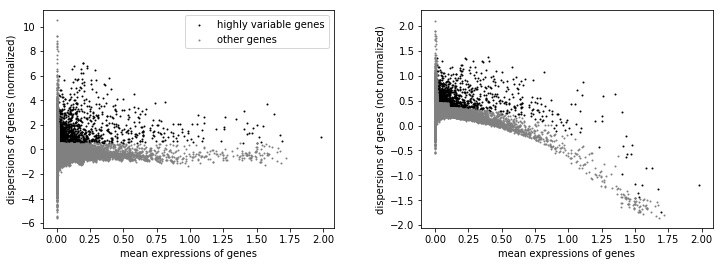

In [6]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 4, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [7]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]

In [8]:
import multiprocessing
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count() - 1)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value = 10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:04:13)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:18)


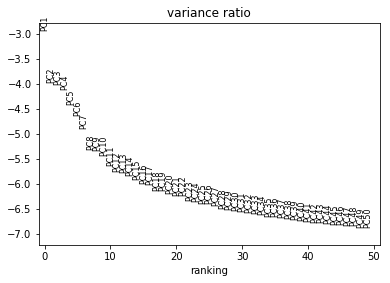

In [9]:
# Principal component analysis
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [10]:
# use bbknn to compute neighbour graph
sc.external.pp.bbknn(adata, batch_key='patient')
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:43)


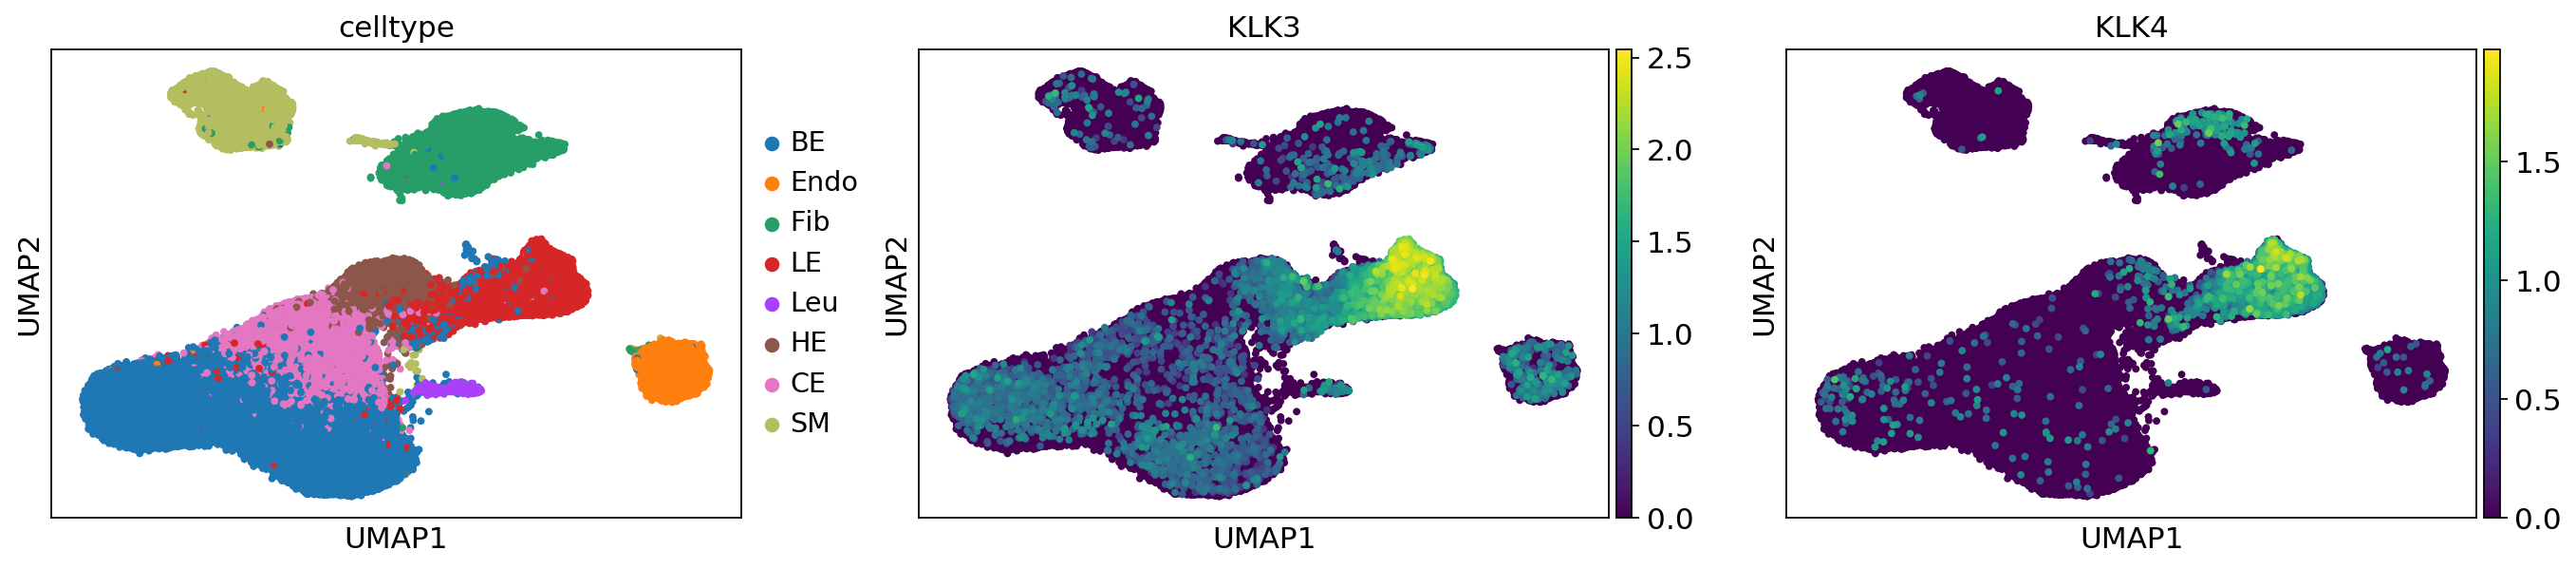

In [11]:
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(adata, color = ['celltype', 'KLK3', 'KLK4'], size = 50, ncols = 3, save = '/henry_celltypes_KLK3_KLK4.pdf')

In [12]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [13]:
# now compute LE-KLK4_score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(adata.obs['LE-KLK4_score'])
mask = adata.obs['LE-KLK4_score']>med
mad = np.median(adata.obs['LE-KLK4_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata.obs['LE-KLK4_score'], loc=med, scale=1.4826*mad)
adata.obs['bh_pval'] = bh(pvals)

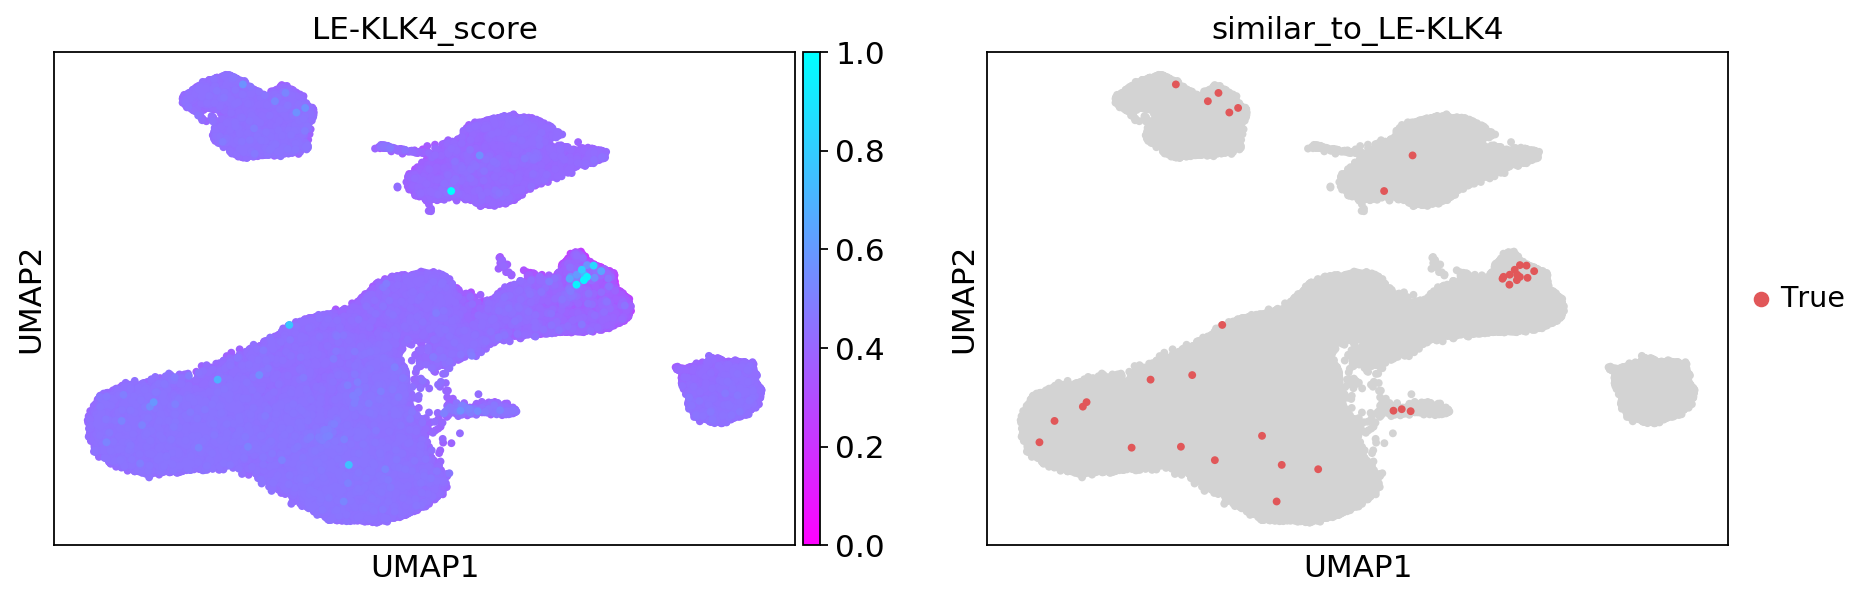

In [18]:
# threshold the p-values to get LE-KLK4 calls.
adata.obs['similar_to_LE-KLK4'] = (adata.obs['bh_pval'] < 0.01) & (adata.obs['LE-KLK4_score'] > 0.5)
adata.obs['similar_to_LE-KLK4'] = adata.obs['similar_to_LE-KLK4'].astype('category')
# visualise the LE-KLK4
adata.uns['similar_to_LE-KLK4_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(adata, color = ['LE-KLK4_score', 'similar_to_LE-KLK4'], size = 50, groups = [True], save = '/Henry_similarity_to_KLK4.pdf', color_map = 'cool_r')

In [19]:
# save the results file
adata.write(results_file, compression = 'gzip')
adata

AnnData object with n_obs × n_vars = 91169 × 1465 
    obs: 'samples', 'orig.ident', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'percent.mito', 'res.1', 'tree.ident', 'res1', 'res1-Stress', 'res.0.5', 'res0.5', 'Lin', 'Merge_Epi.dws.sc_St.dws.sc', 'Merge_Epi.dws.sc_St.dws.sc_NE', 'msamples', 'patient', 'res.0.2', 'res0.2', 'Merge_Epi.dws_St.go', 'Merge_Epi.dws_St.go_NE', 'mLin', 'nCount_RNA', 'nFeature_RNA', 'celltype', 'BE_score', 'HE_score', 'CE_score', 'LE-KLK3_score', 'LE-KLK4_score', 'Fibroblast_score', 'Endothelial_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'similar_to_LE-KLK4'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'celltype_colors', 'similar_to_LE-KLK4_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

# save file location
results_file = 'dataset/henry_merge_sc10x_cellreports_nonimmune.h5ad'
adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 91169 × 1465 
    obs: 'samples', 'orig.ident', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'percent.mito', 'res.1', 'tree.ident', 'res1', 'res1-Stress', 'res.0.5', 'res0.5', 'Lin', 'Merge_Epi.dws.sc_St.dws.sc', 'Merge_Epi.dws.sc_St.dws.sc_NE', 'msamples', 'patient', 'res.0.2', 'res0.2', 'Merge_Epi.dws_St.go', 'Merge_Epi.dws_St.go_NE', 'mLin', 'nCount_RNA', 'nFeature_RNA', 'celltype', 'BE_score', 'HE_score', 'CE_score', 'LE-KLK3_score', 'LE-KLK4_score', 'Fibroblast_score', 'Endothelial_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'similar_to_LE-KLK4'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'neighbors', 'pca', 'similar_to_LE-KLK4_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [3]:
# now compute LE-KLK4_score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(adata.obs['LE-KLK3_score'])
mask = adata.obs['LE-KLK3_score']>med
mad = np.median(adata.obs['LE-KLK3_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata.obs['LE-KLK3_score'], loc=med, scale=1.4826*mad)
adata.obs['bh_pval'] = bh(pvals)

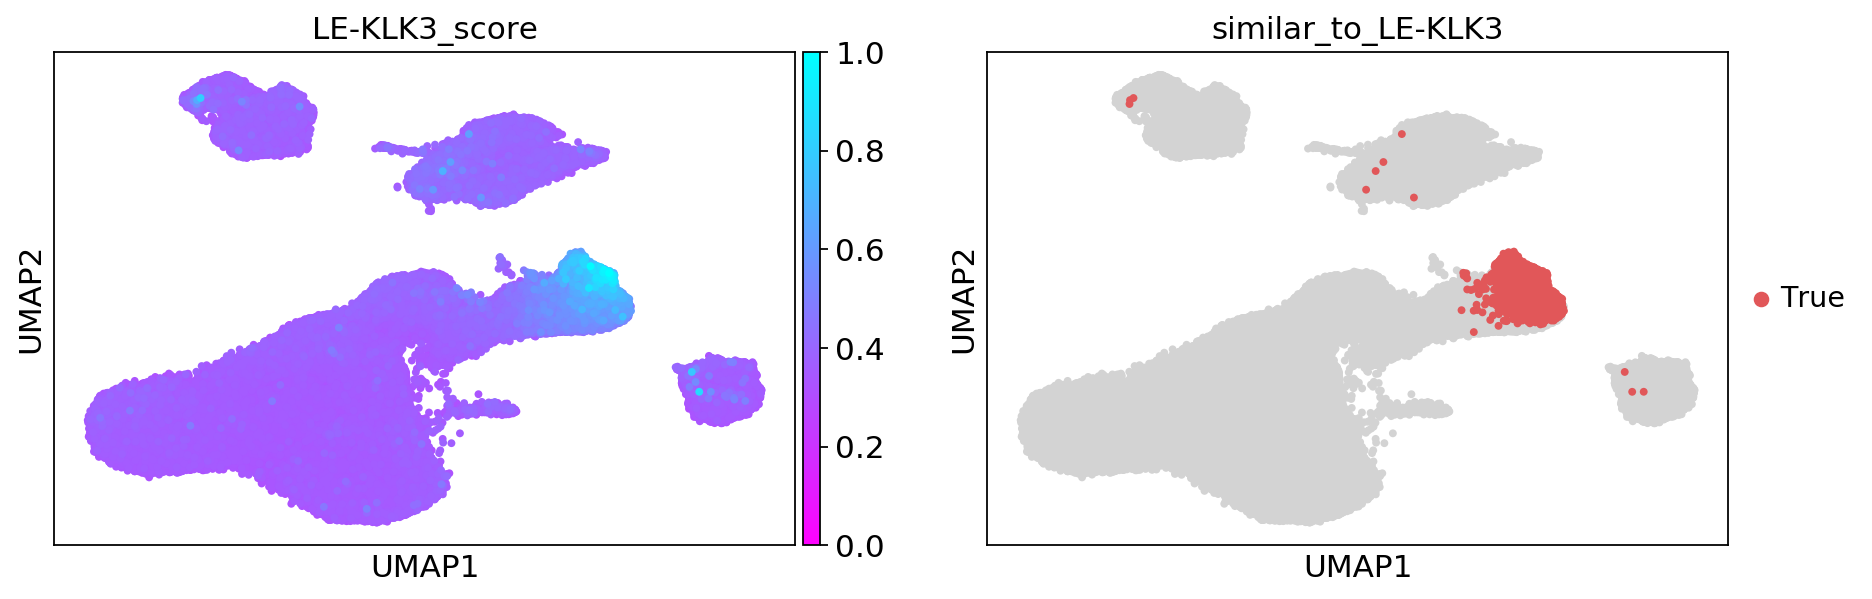

In [5]:
# threshold the p-values to get LE-KLK4 calls.
adata.obs['similar_to_LE-KLK3'] = (adata.obs['bh_pval'] < 0.01) & (adata.obs['LE-KLK3_score'] > 0.5)
adata.obs['similar_to_LE-KLK3'] = adata.obs['similar_to_LE-KLK3'].astype('category')
# visualise the LE-KLK4
adata.uns['similar_to_LE-KLK3_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
# sc.pl.umap(adata, color = ['LE-KLK4_score', 'similar_to_LE-KLK4'], size = 50, groups = [True], save = '/Henry_similarity_to_KLK4.pdf', color_map = 'cool_r')
sc.pl.umap(adata, color = ['LE-KLK3_score', 'similar_to_LE-KLK3'], size = 50, groups = [True], color_map = 'cool_r', save = '/Henry_similarity_to_KLK3.pdf')